# Customer Segmentation
## Strategy development based on customer lifetime value
---

## BACKGROUND

In this notebook, you will learn the most fundamental methodologies used in marketing analytics, and how to apply them to real-life data : segmentation, and lifetime value analysis. I have shown how you can extract, prepare your data, and how to analyse it with python. My goal is to make sure you acquire skills and techniques that can be applied immediately to real-life situations. Simply be aware that these skills are invaluable to have in the marketplace, but hard to learn. Be prepared to spend some time exploring the code on your own.

## PACKAGE IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# DATA PREPERATION

Most data used for data mining was originally collected and preserved for other purposes and needs some refinement before it is ready to use for modeling. The data preparation phase is as follows 
>1. Data Collection
2. Data Processing
3. Data Cleaning
4. Feature Extraction 


## DATA ACQUISATION 

In [2]:
customer_purchases = pd.read_csv("customer_purchases.csv", header = None)
customer_purchases.columns = ['customer_id', 'purchase_amount', 'date_of_purchase']
customer_purchases.date_of_purchase = pd.to_datetime(customer_purchases.date_of_purchase).dt.strftime('%m-%d-%Y')
# now = '01-01-2016'
customer_purchases['days_since'] =  pd.to_datetime(customer_purchases['date_of_purchase']).apply(lambda x: (pd.to_datetime("2016-01-01") - x).days)

In [3]:
customer_purchases.head()

,customer_id,purchase_amount,date_of_purchase,days_since
0,760,25.0,06-11-2009,2395
1,860,50.0,09-28-2012,1190
2,1200,100.0,10-25-2005,3720
3,1420,50.0,09-07-2009,2307
4,1940,70.0,01-25-2013,1071


# FEATURE ENGINEERING  

## COMPUTING RECENCY, FREQUENCY, MONETARY VALUE

In [4]:
## Compute recency, frequency, and monetary_value
def rec_freq_value(x):
    recency        = x['days_since'].min()
    first_purchase = x['days_since'].max()
    frequency      = x['days_since'].count()
    monetary_value = x['purchase_amount'].mean()
    c = ['recency', 'first_purchase', 'frequency', 'monetary_value']
    return pd.Series([recency, first_purchase, frequency, monetary_value], index = c)

In [5]:
customer_purchases_2015 = customer_purchases.groupby('customer_id').apply(rec_freq_value)
print (customer_purchases_2015)

             recency  first_purchase  frequency  monetary_value
customer_id                                                    
10            3799.0          3799.0        1.0       30.000000
80             343.0          3751.0        7.0       71.428571
90             994.0          3783.0       10.0      115.800000
120           1459.0          1459.0        1.0       20.000000
130           2970.0          3917.0        2.0       50.000000
...              ...             ...        ...             ...
263820           1.0             1.0        1.0       10.000000
263870         135.0           135.0        1.0       50.000000
263880          34.0            34.0        1.0       20.000000
263890           5.0             5.0        1.0       54.000000
264200           1.0             1.0        1.0      500.000000

[18417 rows x 4 columns]


In [6]:
customer_purchases_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18417 entries, 10 to 264200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         18417 non-null  float64
 1   first_purchase  18417 non-null  float64
 2   frequency       18417 non-null  float64
 3   monetary_value  18417 non-null  float64
dtypes: float64(4)
memory usage: 719.4 KB


# EXPLORATORY DATA ANALYSIS (EDA)
---
I did visual exploration of the data to understand data better and possibly pick some nuanced patterns. This might enable us to identify the relationship between each one of the features with the overall relationship with credit applications.

> - Build intuition
- Find Patterns

> Features
- First Purchase
- Frequency
- Recency

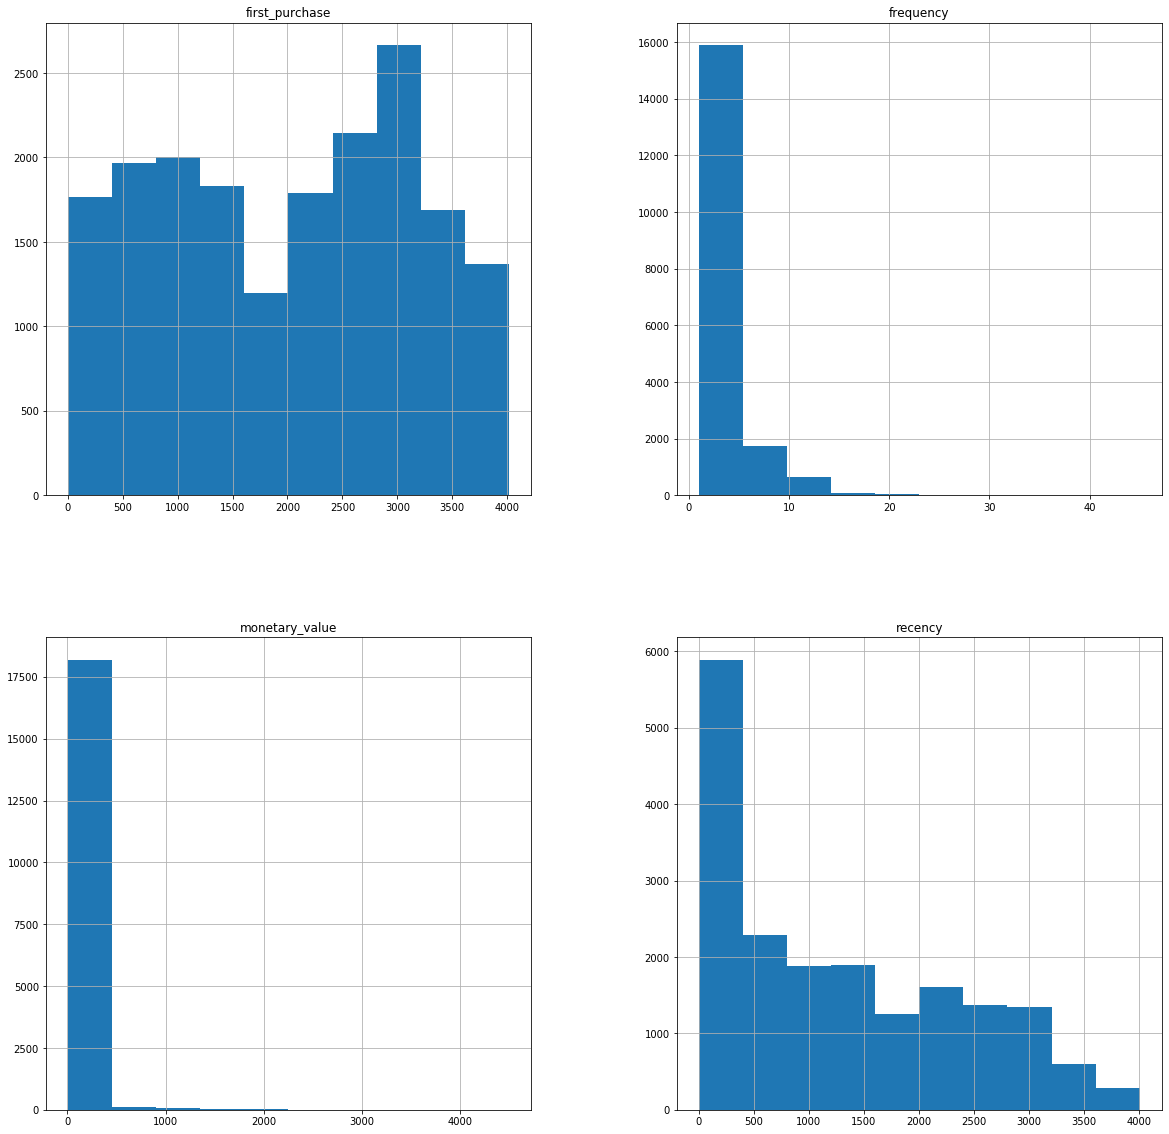

In [7]:
#let's plot the histograms
%matplotlib inline
customer_purchases_2015.hist(figsize = (20, 20))
plt.show()

# MANAGERIAL SEGMENTATION
---
> - Coding managerial segmentation 
  - Simple 2-segment solution based on recency alone
  - A more complex 3-segment solution based on recency alone
  - Complete segment solution using which, and exploiting previous test as input

## SIMPLE 2-SEGMENT SOLUTION BASED ON RECENCY ALONE

In [8]:
# Simple 2-segment solution based on recency alone
customer_purchases_2015['segment'] = np.where(customer_purchases_2015['recency'] > 365*3, 'inactive', 'NA')

In [9]:
#get value counts
customer_purchases_2015['segment'].value_counts() 

NA          9259
inactive    9158
Name: segment, dtype: int64

In [10]:
# Show segmentation results
customer_purchases_2015.groupby(['segment']).agg('mean')

,recency,first_purchase,frequency,monetary_value
segment,,,,
NA,355.990172,1444.879037,3.739713,67.367605
inactive,2186.996615,2556.574034,1.814479,48.112771


## A MORE COMPLEX 3-SEGMENT SOLUTION BASED ON RECENCY ALONE

In [11]:
# A more complex 3-segment solution based on recency alone
customer_purchases_2015['segment'] = np.where(customer_purchases_2015['recency']  > 365*3, 'inactive', np.where(customer_purchases_2015['recency']  > 365*2, 'cold', 'NA'))

In [12]:
#get value counts
customer_purchases_2015['segment'].value_counts() 

inactive    9158
NA          7356
cold        1903
Name: segment, dtype: int64

In [13]:
customer_purchases_2015.groupby(['segment']).agg('mean')

,recency,first_purchase,frequency,monetary_value
segment,,,,
NA,225.040919,1446.685155,4.111338,71.410500
cold,862.171308,1437.897530,2.303205,51.739893
inactive,2186.996615,2556.574034,1.814479,48.112771


## MORE COMPLEX 4-SEGMENT SOLUTION

In [14]:
def four_segment_solution (s):
    s.loc[(s['recency'] > 365*3), 'segment'] = "inactive" # creating a new column seg with our values
    s.loc[(s['recency'] <= 365*3), 'segment'] = "active" # creating a new column seg with our values
    s.loc[(s['recency'] <= 365*3) & (s['recency'] > 365*2), 'segment'] = "cold"
    s.loc[(s['recency'] <= 365*2) & (s['recency'] > 365*1), 'segment'] = "warm"  

In [15]:
four_segment_solution(customer_purchases_2015) 

In [16]:
#get value counts
customer_purchases_2015['segment'].value_counts() 

inactive    9158
active      5398
warm        1958
cold        1903
Name: segment, dtype: int64

In [17]:
customer_purchases_2015.groupby(['segment']).agg('mean')

,recency,first_purchase,frequency,monetary_value
segment,,,,
active,125.976658,1489.139681,4.560763,72.080944
cold,862.171308,1437.897530,2.303205,51.739893
inactive,2186.996615,2556.574034,1.814479,48.112771
warm,498.150664,1329.642492,2.872319,69.562155


## COMPLETE SEGMENT SOLUTION

In [18]:
## Complete segment solution using which, and exploiting previous test as input
def complete_segment_solution (s):
    s.loc[(s['segment'] == "warm") & (s['first_purchase'] <= 365*2), 'segment'] = "new warm"
    s.loc[(s['segment'] == "warm") & (s['monetary_value'] < 100), 'segment'] = "warm low value"
    s.loc[(s['segment'] == "warm") & (s['monetary_value'] >= 100), 'segment'] = "warm high value"
    s.loc[(s['segment'] == "active") & (s['first_purchase'] <= 365), 'segment'] = "new active"   
    s.loc[(s['segment'] == "active") & (s['monetary_value'] < 100), 'segment'] = "active low value"
    s.loc[(s['segment'] == "active") & (s['monetary_value'] >= 100), 'segment'] = "active high value"

In [19]:
# run function
complete_segment_solution(customer_purchases_2015) 

In [20]:
customer_purchases_2015['segment'] = customer_purchases_2015['segment'].astype('category')

In [21]:
#get value counts
customer_purchases_2015['segment'].value_counts() 

inactive             9158
active low value     3313
cold                 1903
new active           1512
new warm              938
warm low value        901
active high value     573
warm high value       119
Name: segment, dtype: int64

In [22]:
# Re-order and display results
customer_purchases_2015['segment'] = customer_purchases_2015['segment'].astype('category')
customer_purchases_2015['segment'].cat.reorder_categories(['inactive',
                                                           'cold',            
                                                           'warm high value',     
                                                           'warm low value',      
                                                           'new warm',            
                                                           'active high value',   
                                                           'active low value' ,   
                                                           'new active'], inplace = True)

In [23]:
# Show segmentation results
customer_purchases_2015.groupby(['segment']).agg('mean')

,recency,first_purchase,frequency,monetary_value
segment,,,,
inactive,2186.996615,2556.574034,1.814479,48.112771
cold,862.171308,1437.897530,2.303205,51.739893
warm high value,474.193277,2037.689076,4.714286,327.407457
warm low value,478.205327,2072.546060,4.531632,38.591926
new warm,520.348614,526.216418,1.044776,66.599026
active high value,109.626527,1999.357766,5.888307,240.045740
active low value,126.694235,2018.981890,5.935406,40.724525
new active,130.600529,134.826058,1.045635,77.133847


# SEGMENTING A DATABASE RETROSPECTIVELY 

In [24]:
## Compute recency, frequency, and monetary_value
def rec_freq_value_2 (x):
    recency        = x['days_since'].min() - 365
    first_purchase = x['days_since'].max() - 365
    frequency      = x['days_since'].count()
    monetary_value = x['purchase_amount'].mean()
    c = ['recency', 'first_purchase', 'frequency', 'monetary_value']
    return pd.Series([recency, first_purchase, frequency, monetary_value], index =c )


In [25]:
customers_2014 = customer_purchases.loc[customer_purchases['days_since']  > 365]

In [26]:
customer_purchases_2014 = customers_2014.groupby('customer_id').apply(rec_freq_value_2)
print (customer_purchases_2014)

             recency  first_purchase  frequency  monetary_value
customer_id                                                    
10            3434.0          3434.0        1.0            30.0
80             243.0          3386.0        6.0            70.0
90             629.0          3418.0       10.0           115.8
120           1094.0          1094.0        1.0            20.0
130           2605.0          3552.0        2.0            50.0
...              ...             ...        ...             ...
235200          50.0            50.0        1.0           100.0
235210         266.0           266.0        1.0           500.0
236310           6.0             6.0        1.0            30.0
236660         538.0           684.0        2.0            75.0
245840          48.0            48.0        1.0            50.0

[16905 rows x 4 columns]


In [27]:
four_segment_solution(customer_purchases_2014)
print(customer_purchases_2014)

             recency  first_purchase  frequency  monetary_value   segment
customer_id                                                              
10            3434.0          3434.0        1.0            30.0  inactive
80             243.0          3386.0        6.0            70.0    active
90             629.0          3418.0       10.0           115.8      warm
120           1094.0          1094.0        1.0            20.0      cold
130           2605.0          3552.0        2.0            50.0  inactive
...              ...             ...        ...             ...       ...
235200          50.0            50.0        1.0           100.0    active
235210         266.0           266.0        1.0           500.0    active
236310           6.0             6.0        1.0            30.0    active
236660         538.0           684.0        2.0            75.0      warm
245840          48.0            48.0        1.0            50.0    active

[16905 rows x 5 columns]


In [28]:
# Complete segment solution using which, and exploiting previous test as input
#run function
complete_segment_solution(customer_purchases_2014) 

In [29]:
#get value counts
customer_purchases_2014['segment'].value_counts() 

inactive             7512
active low value     3011
cold                 2153
new active           1437
new warm             1250
warm low value        956
active high value     475
warm high value       111
Name: segment, dtype: int64

In [30]:
# Re-order and display results
customer_purchases_2014['segment'] = customer_purchases_2014['segment'].astype('category')
customer_purchases_2014['segment'].cat.reorder_categories(['inactive',
                                                           'cold',            
                                                           'warm high value',     
                                                           'warm low value',      
                                                           'new warm',            
                                                           'active high value',   
                                                           'active low value' ,   
                                                           'new active'], inplace = True)

In [31]:
# Show segmentation results
customer_purchases_2014.groupby(['segment']).agg('mean')

,recency,first_purchase,frequency,monetary_value
segment,,,,
inactive,2065.689031,2361.512114,1.730964,48.111199
cold,880.354389,1582.177427,2.254064,51.114605
warm high value,484.270270,1898.135135,4.414414,187.849110
warm low value,478.752092,1958.759414,4.361925,37.382060
new warm,500.717600,506.820000,1.057600,51.367653
active high value,94.829474,1854.406316,5.696842,261.902155
active low value,102.780139,1809.900033,5.633677,40.459174
new active,146.528184,155.676409,1.070981,69.725159


# COMPUTING REVENUE GENERATION PER SEGMENT

In [32]:
# Compute how much revenue is generated by segments
# Notice that people with no revenue in 2015 do NOT appear
customer_purchases['date_of_purchase'] = pd.to_datetime(customer_purchases['date_of_purchase'])  

In [33]:
mask = (customer_purchases['date_of_purchase'] > '2015-1-1') & (customer_purchases['date_of_purchase'] <= '2015-12-31')
# print(customer_purchases.loc[mask])
mask_2 = customer_purchases.loc[mask]
mask_2

,customer_id,purchase_amount,date_of_purchase,days_since
912,131450,100.0,2015-10-06,87
918,198220,20.0,2015-06-06,209
934,153940,30.0,2015-04-06,270
950,222340,500.0,2015-05-27,219
962,159670,80.0,2015-01-23,343
...,...,...,...,...
51202,254130,60.0,2015-10-30,63
51214,141760,50.0,2015-02-12,323
51215,232530,100.0,2015-12-31,1
51231,232850,50.0,2015-10-29,64


In [34]:
def sum_col(x):
    mask = (x['date_of_purchase'] > '2015-1-1') & (x['date_of_purchase'] <= '2015-12-31')
    # print(customer_purchases.loc[mask])
    mask_2 = x.loc[mask]   
    revenue_2015 = mask_2['purchase_amount'].sum()
    #df['C'] = df.sum(axis=1)
    c = ['revenue_2015']
    return pd.Series(revenue_2015, index = c)

In [35]:
revenue_2015 = mask_2.groupby('customer_id').apply(sum_col)
revenue_2015

,revenue_2015
customer_id,
80,80.0
480,45.0
830,50.0
850,60.0
860,60.0
...,...
263820,10.0
263870,50.0
263880,20.0


In [36]:
#revenue_2015.info()
revenue_2015.describe()

,revenue_2015
count,5398.000000
mean,88.624329
std,224.356897
min,5.000000
25%,30.000000
50%,50.000000
75%,85.000000
max,4500.000000


## MERGE 2015 CUSTOMERS AND 2015 REVENUE

In [37]:
## Merge 2015 customers and 2015 revenue 
actual = pd.concat([customer_purchases_2015, revenue_2015], axis = 1, sort=False)
actual

,recency,first_purchase,frequency,monetary_value,segment,revenue_2015
customer_id,,,,,,
10,3799.0,3799.0,1.0,30.000000,inactive,NaN
80,343.0,3751.0,7.0,71.428571,active low value,80.0
90,994.0,3783.0,10.0,115.800000,cold,NaN
120,1459.0,1459.0,1.0,20.000000,inactive,NaN
130,2970.0,3917.0,2.0,50.000000,inactive,NaN
...,...,...,...,...,...,...
263820,1.0,1.0,1.0,10.000000,new active,10.0
263870,135.0,135.0,1.0,50.000000,new active,50.0
263880,34.0,34.0,1.0,20.000000,new active,20.0


In [38]:
actual.isnull().sum().sum()

13019

In [39]:
actual['revenue_2015'].fillna(0, inplace=True)

## SHOW AVERAGE REVENUE PER CUSTOMER AND PER SEGMENT

In [40]:
# Show average revenue per customer and per segment
actual.groupby(['segment'])['revenue_2015'].agg('mean')

segment
inactive               0.000000
cold                   0.000000
warm high value        0.000000
warm low value         0.000000
new warm               0.000000
active high value    323.568935
active low value      52.306043
new active            79.166144
Name: revenue_2015, dtype: float64

## MERGE 2014 CUSTOMERS AND 2015 REVENUE

In [41]:
customer_purchases_2014

,recency,first_purchase,frequency,monetary_value,segment
customer_id,,,,,
10,3434.0,3434.0,1.0,30.0,inactive
80,243.0,3386.0,6.0,70.0,active low value
90,629.0,3418.0,10.0,115.8,warm high value
120,1094.0,1094.0,1.0,20.0,cold
130,2605.0,3552.0,2.0,50.0,inactive
...,...,...,...,...,...
235200,50.0,50.0,1.0,100.0,new active
235210,266.0,266.0,1.0,500.0,new active
236310,6.0,6.0,1.0,30.0,new active


In [42]:
revenue_2015

,revenue_2015
customer_id,
80,80.0
480,45.0
830,50.0
850,60.0
860,60.0
...,...
263820,10.0
263870,50.0
263880,20.0


In [43]:
forward = pd.merge(customer_purchases_2014, revenue_2015,  how='left', left_on=['customer_id'], right_on = ['customer_id'])
forward

,recency,first_purchase,frequency,monetary_value,segment,revenue_2015
customer_id,,,,,,
10,3434.0,3434.0,1.0,30.0,inactive,NaN
80,243.0,3386.0,6.0,70.0,active low value,80.0
90,629.0,3418.0,10.0,115.8,warm high value,NaN
120,1094.0,1094.0,1.0,20.0,cold,NaN
130,2605.0,3552.0,2.0,50.0,inactive,NaN
...,...,...,...,...,...,...
235200,50.0,50.0,1.0,100.0,new active,NaN
235210,266.0,266.0,1.0,500.0,new active,NaN
236310,6.0,6.0,1.0,30.0,new active,NaN


In [44]:
forward.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16905 entries, 10 to 245840
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   recency         16905 non-null  float64 
 1   first_purchase  16905 non-null  float64 
 2   frequency       16905 non-null  float64 
 3   monetary_value  16905 non-null  float64 
 4   segment         16905 non-null  category
 5   revenue_2015    3886 non-null   float64 
dtypes: category(1), float64(5)
memory usage: 809.3 KB


In [45]:
forward['revenue_2015'].fillna(0, inplace = True)
forward

,recency,first_purchase,frequency,monetary_value,segment,revenue_2015
customer_id,,,,,,
10,3434.0,3434.0,1.0,30.0,inactive,0.0
80,243.0,3386.0,6.0,70.0,active low value,80.0
90,629.0,3418.0,10.0,115.8,warm high value,0.0
120,1094.0,1094.0,1.0,20.0,cold,0.0
130,2605.0,3552.0,2.0,50.0,inactive,0.0
...,...,...,...,...,...,...
235200,50.0,50.0,1.0,100.0,new active,0.0
235210,266.0,266.0,1.0,500.0,new active,0.0
236310,6.0,6.0,1.0,30.0,new active,0.0


## SHOW AVERAGE REVENUE PER CUSTOMER AND PER SEGMENT

In [46]:
# Show average revenue per customer and per segment
forward.groupby(['segment'])['revenue_2015'].agg('mean')

segment
inactive               2.949466
cold                   6.108221
warm high value      114.459459
warm low value        13.494770
new warm               5.064000
active high value    254.077895
active low value      41.896556
new active            31.046625
Name: revenue_2015, dtype: float64

In [47]:
# Re-order and display results
forward['segment'] = forward['segment'].astype('category')
forward['segment'].cat.reorder_categories(['inactive',
                                           'cold',            
                                            'warm high value',     
                                            'warm low value',      
                                            'new warm',            
                                            'active high value',   
                                            'active low value' ,   
                                            'new active'], inplace = True)

In [48]:
## Show average revenue per customer and per segment
forward.groupby(['segment'])['revenue_2015'].agg('mean')

segment
inactive               2.949466
cold                   6.108221
warm high value      114.459459
warm low value        13.494770
new warm               5.064000
active high value    254.077895
active low value      41.896556
new active            31.046625
Name: revenue_2015, dtype: float64

In [49]:
r = forward.groupby(['segment'])['revenue_2015'].agg('mean')
print(r)

segment
inactive               2.949466
cold                   6.108221
warm high value      114.459459
warm low value        13.494770
new warm               5.064000
active high value    254.077895
active low value      41.896556
new active            31.046625
Name: revenue_2015, dtype: float64


In [50]:
revenue_2015_segment = forward.groupby(['segment'])['revenue_2015'].aggregate(np.mean).reset_index().sort_values('revenue_2015', ascending = False)

In [51]:
revenue_2015_segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 5 to 0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   segment       8 non-null      category
 1   revenue_2015  8 non-null      float64 
dtypes: category(1), float64(1)
memory usage: 520.0 bytes


In [52]:
revenue_2015_segment

,segment,revenue_2015
5,active high value,254.077895
2,warm high value,114.459459
6,active low value,41.896556
7,new active,31.046625
3,warm low value,13.494770
1,cold,6.108221
4,new warm,5.064000
0,inactive,2.949466


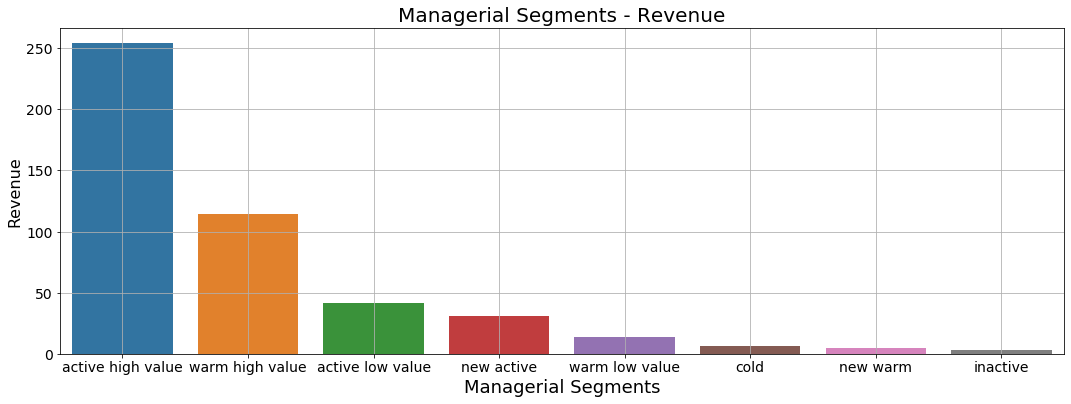

In [53]:
## number of CRG per credit application
import seaborn as sns
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = "segment", y = "revenue_2015", data = revenue_2015_segment, order = revenue_2015_segment['segment'])
plt.grid()
plt.title("Managerial Segments - Revenue", fontsize = 20)
plt.xlabel("Managerial Segments", fontsize = 18)
plt.ylabel("Revenue", fontsize = 16)
plt.tick_params(labelsize = 14)
#plt.savefig('Managerial Segments - Revenue.png', dpi = 600)

# RFM SEGMENTATION

In [54]:
customer_purchases.head()
customer_purchases_rfm = customer_purchases.groupby('customer_id').apply(rec_freq_value)
del customer_purchases_rfm['first_purchase']
print (customer_purchases_rfm)

             recency  frequency  monetary_value
customer_id                                    
10            3799.0        1.0       30.000000
80             343.0        7.0       71.428571
90             994.0       10.0      115.800000
120           1459.0        1.0       20.000000
130           2970.0        2.0       50.000000
...              ...        ...             ...
263820           1.0        1.0       10.000000
263870         135.0        1.0       50.000000
263880          34.0        1.0       20.000000
263890           5.0        1.0       54.000000
264200           1.0        1.0      500.000000

[18417 rows x 3 columns]


# HIERARCHICAL SEGMENTATION

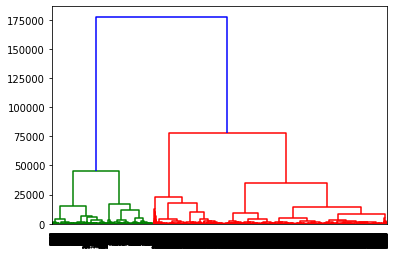

In [55]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(customer_purchases_rfm , method = 'ward'))
image = 'customer_hc.pdf'
plt.savefig(image)
from IPython.display import HTML
HTML('<a href ="{0}" download>Click here to download {0}</a>'.format(image))

In [56]:
# create clusters
model = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
model.fit(customer_purchases_rfm)
labels = model.labels_

In [57]:
import sys
import numpy
numpy.set_printoptions(threshold = sys.maxsize)
print(labels)

[1 2 0 0 1 1 3 3 1 4 1 3 4 1 0 3 0 2 1 1 1 3 0 3 0 3 1 0 1 2 2 2 1 1 1 4 1
 0 2 4 2 0 2 0 2 2 1 4 2 2 1 2 2 0 1 4 0 3 2 2 2 2 4 2 4 1 2 1 2 1 1 4 2 0
 0 1 2 1 3 1 4 1 2 0 2 0 0 2 1 0 0 2 1 1 1 1 1 1 0 0 0 2 3 1 4 2 1 4 3 3 1
 2 3 0 2 0 1 2 1 2 2 1 3 3 1 2 1 1 2 1 1 2 1 4 2 1 1 0 1 2 1 2 1 0 0 1 0 2
 1 1 2 2 2 1 1 2 2 0 1 3 2 0 0 2 0 2 1 1 2 2 0 1 0 2 2 4 2 4 0 3 2 3 2 1 2
 4 4 1 2 2 1 0 4 2 1 1 1 1 2 0 1 2 0 2 2 1 1 4 4 2 3 2 1 3 0 2 1 4 1 2 0 4
 1 2 3 1 3 0 0 2 1 2 0 2 2 1 2 1 1 3 0 1 3 3 1 0 3 2 1 2 1 2 2 2 2 2 2 3 2
 1 2 3 4 4 3 1 2 1 2 3 2 1 0 2 0 4 4 3 3 2 3 0 0 0 0 2 4 3 1 2 1 2 1 1 1 1
 0 2 1 1 2 1 0 1 1 3 2 1 1 1 2 0 0 0 1 2 2 1 1 2 1 3 4 0 3 0 1 2 1 2 0 3 2
 2 1 1 1 2 2 0 2 3 4 0 1 3 3 1 2 1 3 2 4 2 4 1 1 1 3 3 0 4 1 2 2 1 2 2 1 1
 2 4 2 2 2 1 3 2 3 4 2 2 0 1 1 2 0 2 2 1 1 1 1 1 3 1 1 2 3 0 1 1 3 2 2 1 0
 2 1 1 0 1 1 2 1 0 4 4 3 0 0 2 2 1 2 2 2 2 3 1 2 2 2 2 3 4 0 1 3 1 1 0 0 0
 2 2 2 2 0 4 3 0 2 2 4 0 0 2 2 1 1 0 1 2 0 2 2 4 0 2 0 0 0 2 2 2 0 4 1 2 1
 1 2 0 1 0 2 1 1 0 1 1 1 

# KMeans CLUSTERING

In [58]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_purchases_rfm)

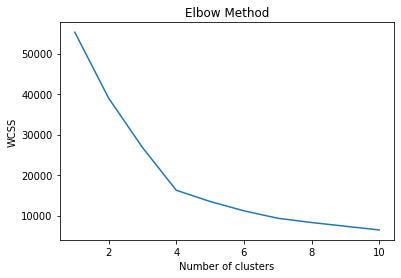

In [59]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 14)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [60]:
# # retrieve scores (move CustomerID to index to make later review easier)
scores_pd = customer_purchases_rfm.copy()
#scores_pd.set_index('customer_id', drop = True, inplace=True)

# train the tsne model and compute x and y axes for our values 
tsne = TSNE(n_components=2, perplexity=40, n_iter = 1000)
tsne_results = tsne.fit_transform(scores_pd)

# return the axes assignments to our metrics dataset
scores_pd['tsne_one'] = tsne_results[:, 0]
scores_pd['tsne_two'] = tsne_results[:, 1]

##  EXPLORE POTENTIAL CLUSTERING 

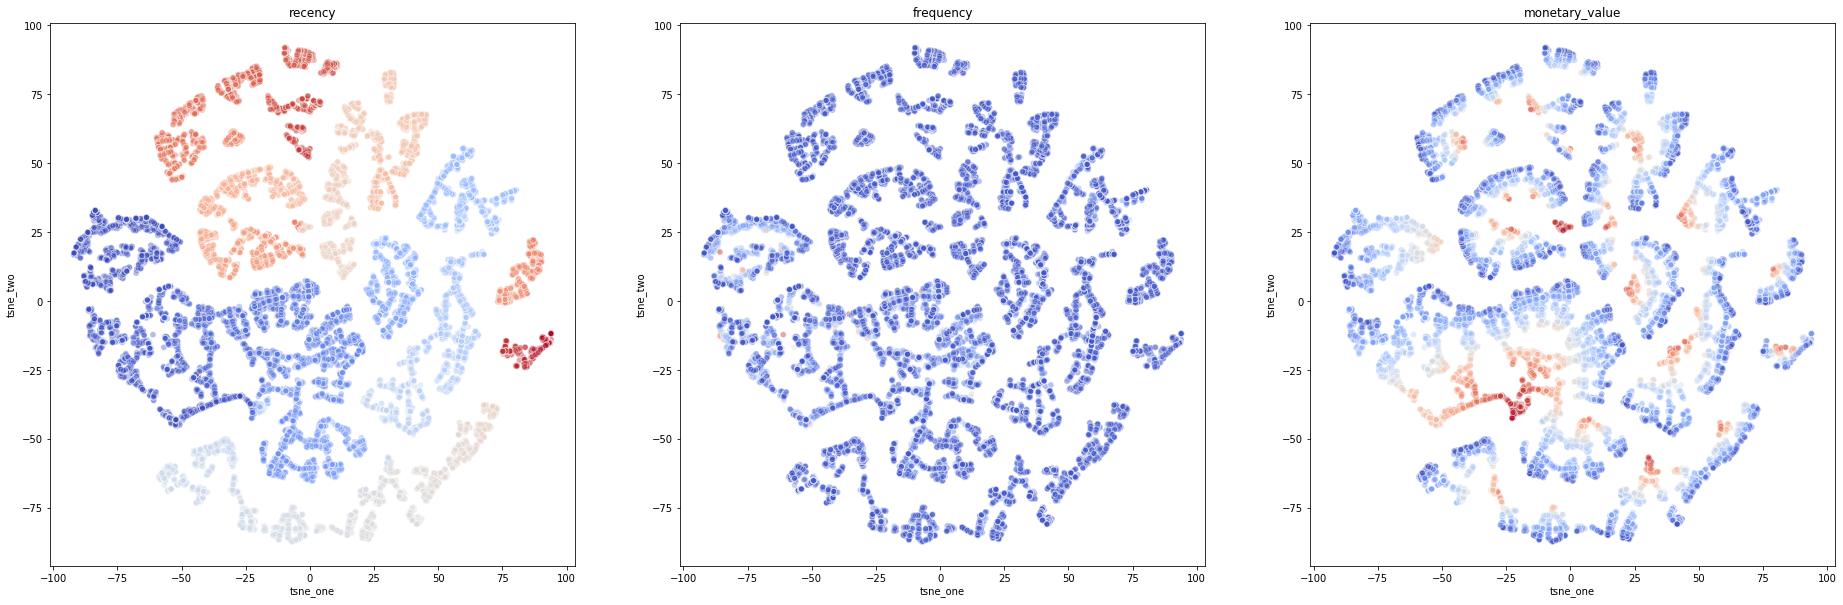

In [61]:
## configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols = 3, squeeze = True, figsize=(32,10))

for i, metric in enumerate(['recency', 'frequency', 'monetary_value']):
  
## unique values for this metric
  n = scores_pd[[format(metric)]].nunique()[0]
  
## use metric name as chart title
  axes[i].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue=format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=scores_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i]
    )

In [62]:
# from sklearn.metrics import silhouette_score
km = KMeans(
  n_clusters = 5, 
  max_iter = 300, 
  n_init = 10,
  random_state = 14
  )
_ = km.fit(scaled_features)

In [63]:
scores_pd['cluster'] = km.predict(customer_purchases_rfm)
scores_pd.head()

,recency,frequency,monetary_value,tsne_one,tsne_two,cluster
customer_id,,,,,,
10,3799.0,1.0,30.000000,87.999596,-19.279898,2
80,343.0,7.0,71.428571,2.046822,-34.642818,3
90,994.0,10.0,115.800000,46.048882,-16.293524,3
120,1459.0,1.0,20.000000,14.829012,-82.309792,2
130,2970.0,2.0,50.000000,-49.621964,58.110359,2


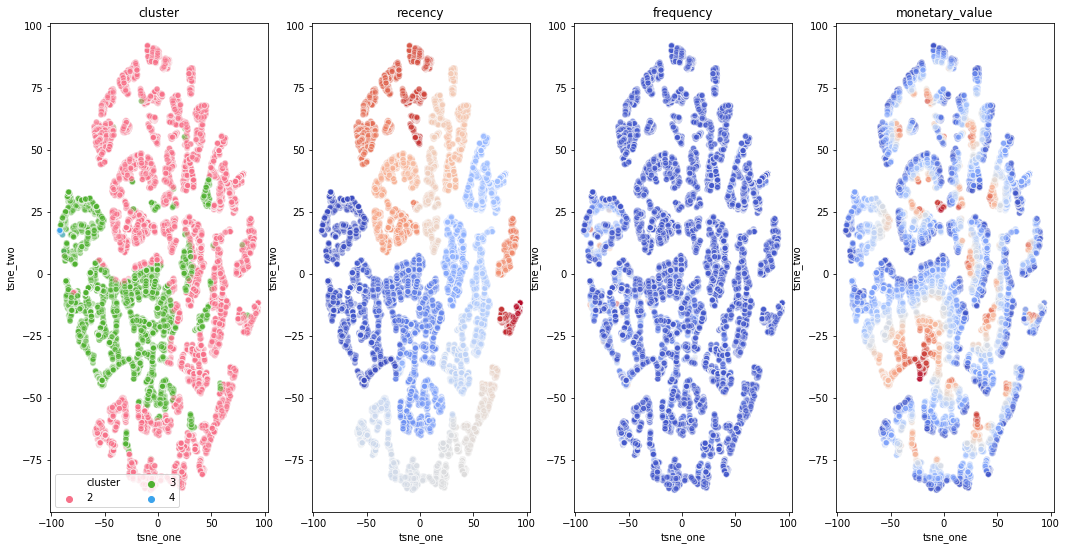

In [64]:
f, axes = plt.subplots(nrows = 1, ncols = 4, squeeze = True, figsize = (18, 9))

# chart the cluster assignments
axes[0].set_title('cluster')
sns.scatterplot(
  x ='tsne_one',
  y ='tsne_two',
  hue = 'cluster',
  palette = sns.color_palette('husl', scores_pd[['cluster']].nunique()[0]),
  data = scores_pd,
  legend = 'brief',
  alpha = 0.4,
  ax = axes[0]
  )
axes[0].legend(loc='lower left', ncol=2, fancybox=True)

# chart the RFM scores
for i, metric in enumerate(['recency', 'frequency', 'monetary_value']):
  
  # unique values for this metric
  n = scores_pd[[format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i+1].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x = 'tsne_one',
    y ='tsne_two',
    hue = format(metric),
    palette = sns.color_palette('coolwarm', n),
    data = scores_pd,
    legend = False,
    alpha = 0.4,
      
    ax = axes[i + 1]
    )

# CUSTOMER LIFETIME VALUE

## COMPUTE TRANSITION MATRIX

In [65]:
# Compute transition matrix
customer_purchases_combined = pd.merge(customer_purchases_2014, customer_purchases_2015,  how = 'left', left_on=['customer_id'], right_on = ['customer_id'])
customer_purchases_combined

,recency_x,first_purchase_x,frequency_x,monetary_value_x,segment_x,recency_y,first_purchase_y,frequency_y,monetary_value_y,segment_y
customer_id,,,,,,,,,,
10,3434.0,3434.0,1.0,30.0,inactive,3799.0,3799.0,1.0,30.000000,inactive
80,243.0,3386.0,6.0,70.0,active low value,343.0,3751.0,7.0,71.428571,active low value
90,629.0,3418.0,10.0,115.8,warm high value,994.0,3783.0,10.0,115.800000,cold
120,1094.0,1094.0,1.0,20.0,cold,1459.0,1459.0,1.0,20.000000,inactive
130,2605.0,3552.0,2.0,50.0,inactive,2970.0,3917.0,2.0,50.000000,inactive
...,...,...,...,...,...,...,...,...,...,...
235200,50.0,50.0,1.0,100.0,new active,415.0,415.0,1.0,100.000000,new warm
235210,266.0,266.0,1.0,500.0,new active,631.0,631.0,1.0,500.000000,new warm
236310,6.0,6.0,1.0,30.0,new active,371.0,371.0,1.0,30.000000,new warm


In [66]:
# table(new_data$segment.x, new_data$segment.y)
customer_transition_matrix = pd.crosstab(customer_purchases_combined['segment_x'], customer_purchases_combined['segment_y'])

In [67]:
customer_transition_matrix 

segment_y,inactive,cold,warm high value,warm low value,new warm,active high value,active low value
segment_x,,,,,,,
inactive,7227,0,0,0,0,35,250
cold,1931,0,0,0,0,22,200
warm high value,0,75,0,0,0,35,1
warm low value,0,689,0,0,0,1,266
new warm,0,1139,0,0,0,15,96
active high value,0,0,119,0,0,354,2
active low value,0,0,0,901,0,22,2088
new active,0,0,0,0,938,89,410


In [68]:
np.sum(customer_transition_matrix, axis = 1)

segment_x
inactive             7512
cold                 2153
warm high value       111
warm low value        956
new warm             1250
active high value     475
active low value     3011
new active           1437
dtype: int64

In [69]:
customer_transition_matrix = customer_transition_matrix/np.sum(customer_transition_matrix, axis = 1)
customer_transition_matrix['new active'].fillna(0, inplace = True)
customer_transition_matrix 

,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
segment_x,,,,,,,,
inactive,0.962061,0.000000,0.000000,0.000000,0.0000,0.073684,0.083029,0.0
cold,0.257055,0.000000,0.000000,0.000000,0.0000,0.046316,0.066423,0.0
warm high value,0.000000,0.034835,0.000000,0.000000,0.0000,0.073684,0.000332,0.0
warm low value,0.000000,0.320019,0.000000,0.000000,0.0000,0.002105,0.088343,0.0
new warm,0.000000,0.529029,0.000000,0.000000,0.0000,0.031579,0.031883,0.0
active high value,0.000000,0.000000,1.072072,0.000000,0.0000,0.745263,0.000664,0.0
active low value,0.000000,0.000000,0.000000,0.942469,0.0000,0.046316,0.693457,0.0
new active,0.000000,0.000000,0.000000,0.000000,0.7504,0.187368,0.136167,0.0


## USE TRANSITION MATRIX TO MAKE PREDICTIONS 

In [70]:
# Initialize a matrix with the number of customers in each segment today and after 10 periods
segments = np.zeros((8, 11))
column_names = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
row_names  = ['inactive', 'cold', 'warm high value', 'warm low value', 'new warm', 'active high value', 'active low value', 'new active']

In [71]:
customer_purchases_segement_2015 = customer_purchases_2015['segment'].value_counts()
customer_purchases_segement_2015

inactive             9158
active low value     3313
cold                 1903
new active           1512
new warm              938
warm low value        901
active high value     573
warm high value       119
Name: segment, dtype: int64

In [72]:
customer_purchases_segement = pd.DataFrame(segments, columns = column_names, index = row_names)
customer_purchases_segement['2015'] = customer_purchases_segement_2015.iloc[0:9]
customer_purchases_segement

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cold,1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm high value,119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm low value,901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new warm,938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active high value,573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active low value,3313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new active,1512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
for i in range(1,11): 
    customer_purchases_segement.iloc[:,i] = np.matmul(customer_purchases_segement.iloc[:,i-1], customer_transition_matrix)
    customer_purchases_segement

# COMPUTE THE (DISCOUNTED) CLV OF A DATABASE
##  Yearly Revenue Per Segment

In [74]:
# Yearly Revenue Per Segment
# This comes directly from module 2, lines 160-161
yearly_revenue = np.array([0, 0, 0, 0, 0, 323.57, 52.31, 79.17])
yearly_revenue

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  , 323.57,  52.31,  79.17])

## Compute Revenue Per Segment

In [75]:
# Compute revenue per segment
revenue_per_segment = customer_purchases_segement.mul(yearly_revenue, axis = 0)
revenue_per_segment 

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cold,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
warm high value,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
warm low value,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
new warm,0.00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
active high value,185405.61,539393.233600,716353.033694,874590.690736,1.001679e+06,1.108430e+06,1.197756e+06,1.272439e+06,1.334881e+06,1.387079e+06,1.430708e+06
active low value,173303.03,183085.747038,186483.718264,190041.202540,1.913726e+05,1.924827e+05,1.933008e+05,1.938894e+05,1.943104e+05,1.946071e+05,1.948123e+05
new active,119705.04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Compute Yearly Revenue

In [76]:
# Compute yearly revenue
yearly_revenue = (revenue_per_segment.iloc[:, 0:11]
                    .sum()
                    .reset_index()
                    .set_axis(['year', 'cum_revenue'], axis = 1, inplace=False))
                      
yearly_revenue     

,year,cum_revenue
0,2015,4.784137e+05
1,2016,7.224790e+05
2,2017,9.028368e+05
3,2018,1.064632e+06
4,2019,1.193051e+06
5,2020,1.300912e+06
6,2021,1.391057e+06
7,2022,1.466329e+06
8,2023,1.529191e+06
9,2024,1.581687e+06


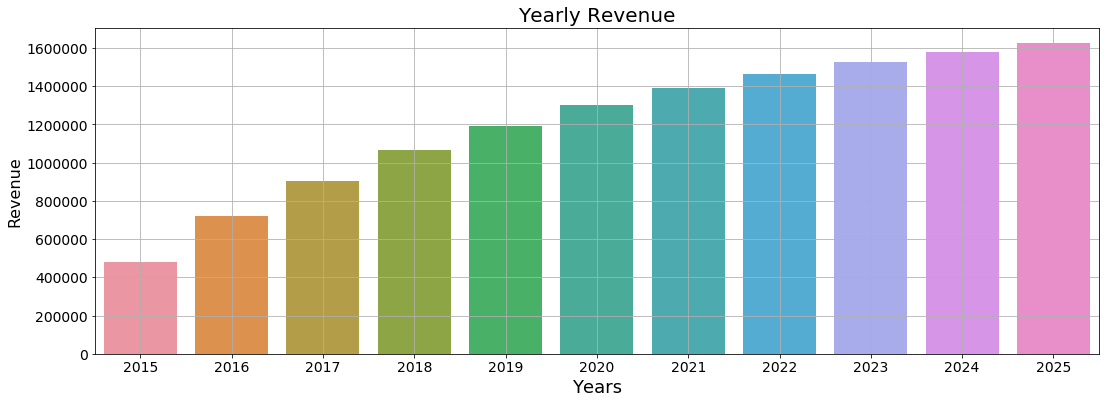

In [77]:
## yearly revenue
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = "year", y = "cum_revenue", data = yearly_revenue)
plt.grid()
plt.title("Yearly Revenue", fontsize = 20)
plt.xlabel("Years", fontsize = 18)
plt.ylabel("Revenue", fontsize = 16)
plt.tick_params(labelsize = 14)
plt.savefig('Yearly Revenue - Revenue.png', dpi = 600)

## Compute Discounted Yearly Revenue

In [78]:
# Compute discounted yearly revenue
discount = np.array([1.0000000, 0.9090909, 0.8264463, 0.7513148, 0.6830135, 0.6209213, 0.5644739, 0.5131581, 0.4665074, 0.4240976,0.3855433])

In [79]:
disc_yearly_revenue = yearly_revenue.copy()
disc_yearly_revenue['cum_revenue'] = round(disc_yearly_revenue['cum_revenue'].multiply(discount, axis = 0))
disc_yearly_revenue

,year,cum_revenue
0,2015,478414.0
1,2016,656799.0
2,2017,746146.0
3,2018,799874.0
4,2019,814870.0
5,2020,807764.0
6,2021,785215.0
7,2022,752458.0
8,2023,713379.0
9,2024,670789.0


## Compute Discounted Cumulated Revenue

In [81]:
# Compute discounted cumulated revenue
disc_cumulated_revenue = yearly_revenue.copy()
disc_cumulated_revenue['cum_revenue'] = round(yearly_revenue['cum_revenue'].cumsum())
disc_cumulated_revenue

,year,cum_revenue
0,2015,478414.0
1,2016,1200893.0
2,2017,2103729.0
3,2018,3168361.0
4,2019,4361413.0
5,2020,5662325.0
6,2021,7053382.0
7,2022,8519710.0
8,2023,10048902.0
9,2024,11630588.0


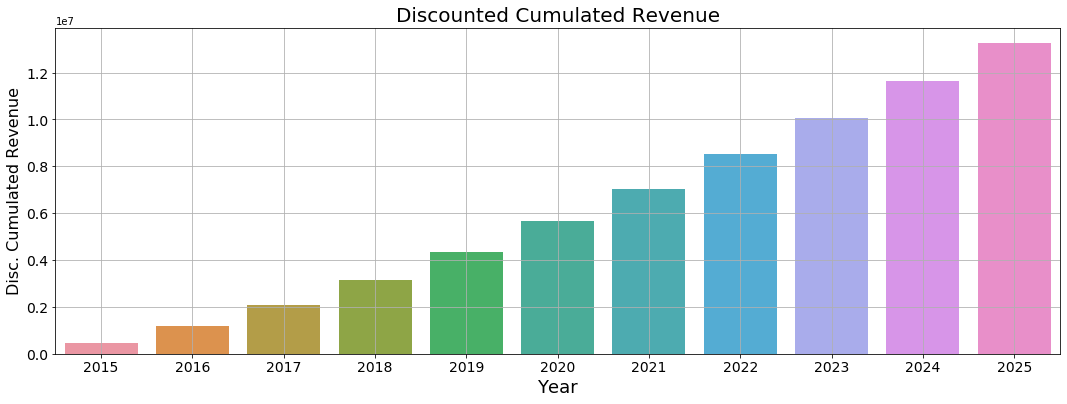

In [82]:
## discounted cumulated revenue
import seaborn as sns
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = "year", y = "cum_revenue", data = disc_cumulated_revenue)
plt.grid()
plt.title("Discounted Cumulated Revenue", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Disc. Cumulated Revenue", fontsize = 16)
plt.tick_params(labelsize = 14)
#plt.savefig('Discounted Cumulated Revenue - Revenue.png', dpi = 600)

In [83]:
# What is the database worth?
print(disc_cumulated_revenue.iloc[-1:, 1][10] - yearly_revenue.iloc[:1, 1][0])

12777695.32
